<a href="https://colab.research.google.com/github/Escher0921/Escher0921/blob/main/%D0%90%D1%82%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предисловие:
Я работаю в организации занимающейся учетом школьного питания и автоматизации связанных процессов. Многие организации оказывающие кейтеринговые услуги стараются сократить свои издержки, поэтому им требуется заранее знать ориетировочное количество порций еды, которое требуется поставить в образовательное учреждение.

# Постановка цели
Для аттестационной работы я решил попробовать использовать машинное обучения для полученния данных по возможному кол-ву порций завтраков, которые требуется заранее подготовить для отправки в образовательное учреждение. 
Целью работы я ставлю определить насколько актуально использование машинного обучения в данном вопросе, т.к. данный функционал может помочь в оптимизации издержек и, как следствие, может привести к экономической выгоде.

In [ ]:
!pip install sklearn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from google.colab import drive
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('drive')

Mounted at drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Python/Итоговая аттестация/Исходный набор данных_2.csv', sep=';')

In [ ]:
df['DATEP'] = pd.to_datetime(df['DATEP'], format='%Y-%m-%d')

In [ ]:
# В качестве параметров для обучения мы будем использвать код учреждения,
# дату, в разбивке на год, месяц, день, день недели и номер дня в году
df['Year'] = df['DATEP'].dt.year
df['Month'] = df['DATEP'].dt.month
df['Day'] = df['DATEP'].dt.day
df['Dayofweek'] = df['DATEP'].dt.dayofweek+1
df['Dayofyear'] = df['DATEP'].dt.dayofyear
df.rename(columns = {'SCHOOL_ID' : 'Школа', 'kolvo' : 'Количество', 
                     'Year' : 'Год', 'Month' : 'Месяц', 'Day' : 'День', 
                     'Dayofweek' : 'День недели', 'Dayofyear' : 'День в году'}, 
                    inplace = True)
col2use = ['Школа','Год','Месяц','День','День недели','День в году']

In [ ]:
# Так будет выглядеть наш датасет после разбивки даты
df.head(1)

,Школа,DATEP,Количество,Год,Месяц,День,День недели,День в году
0,2000023,2018-09-03,132,2018,9,3,1,246


In [ ]:
# Разобъем датасет:
# X - данные на основание которых будем делать предикт
# Y - данные которые хотим получить
y = df['Количество']
X = df[['Школа','Год','Месяц', 'День','День недели','День в году']]

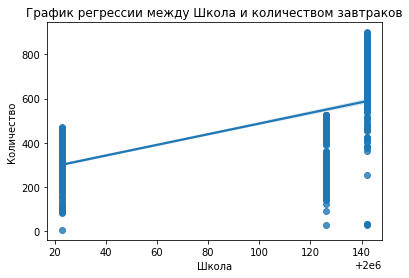

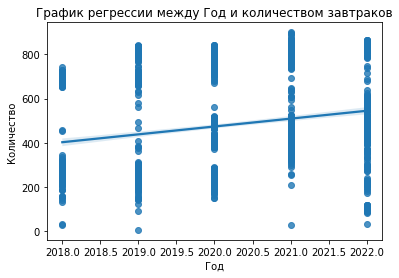

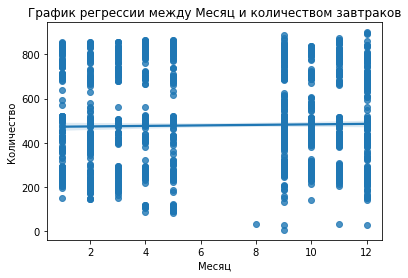

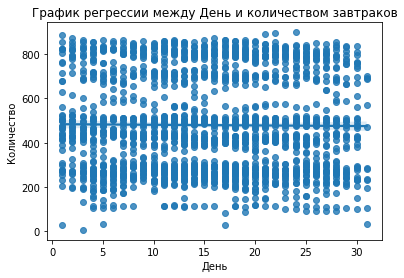

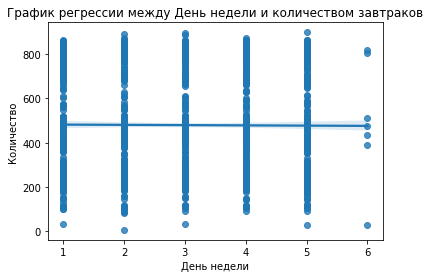

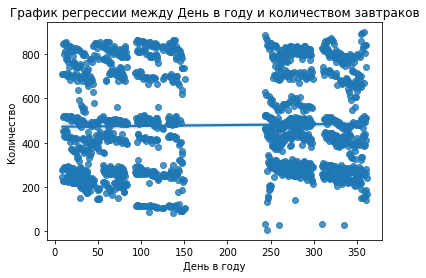

In [ ]:
for col in col2use:
    plt.figure()
    sns.regplot(x=col, y='Количество', data=df).set(title=f'График регрессии между {col} и количеством завтраков')

In [ ]:
# Разобьем наш датасет на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
X_train , X_test , y_train, y_test = train_test_split(X, y, train_size=0.75, random_state = 1 )

In [ ]:
# В качестве моделей используем обычную линейную регрессию и 
# модуль GridSearchCV с помощью которого попробуем определить основные параметры

folds = KFold(n_splits = 4, shuffle = True, random_state = 1)

# Зададим кол-во параметров, у нас их 6
hyper_params = [{'n_features_to_select': list(range(1, 7))}]

# Создадим нашу модель линейной регресси и натренируем её
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# Зададим параметры для GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# Обучим модель для GridSearchCV
model_cv.fit(X_train, y_train)                  

Fitting 4 folds for each of 6 candidates, totalling 24 fits


GridSearchCV(cv=KFold(n_splits=4, random_state=1, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6]}],
             return_train_score=True, scoring='r2', verbose=1)

In [ ]:
# Посмотрим результаты нашей модели с GridSearchCV
# Видим что лучший результат достигается со всеми 6-ю параметрами
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.006678,0.001222,0.001876,0.000076,1,{'n_features_to_select': 1},0.061441,0.068504,0.040037,0.051921,0.055476,0.010681,6,0.055675,0.053508,0.061815,0.058471,0.057367,0.003113
1,0.005495,0.000225,0.001915,0.000054,2,{'n_features_to_select': 2},0.056299,0.076928,0.050488,0.053696,0.059353,0.010354,5,0.057121,0.058828,0.066449,0.066057,0.062114,0.004185
2,0.004867,0.000142,0.100756,0.171252,3,{'n_features_to_select': 3},0.058890,0.072685,0.050261,0.434941,0.154194,0.162286,4,0.064216,0.059550,0.066803,0.389138,0.144927,0.141020
3,0.005196,0.000964,0.002331,0.000486,4,{'n_features_to_select': 4},0.058281,0.070565,0.365300,0.435810,0.232489,0.169960,3,0.064273,0.059968,0.413481,0.389239,0.231740,0.169843
4,0.004026,0.001151,0.002120,0.000454,5,{'n_features_to_select': 5},0.057199,0.401887,0.365300,0.434811,0.314799,0.150744,2,0.064548,0.402453,0.413511,0.389359,0.317468,0.146273
5,0.003012,0.000158,0.001925,0.000057,6,{'n_features_to_select': 6},0.383554,0.402880,0.365541,0.435061,0.396759,0.025756,1,0.408766,0.402666,0.413525,0.389383,0.403585,0.009058


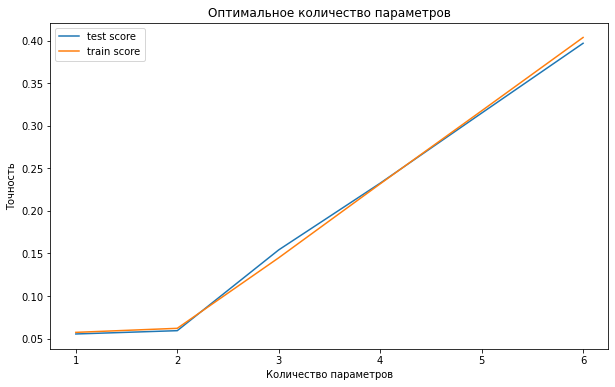

In [ ]:
# Визуализируем результаты на графике
plt.figure(figsize=(10,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('Количество параметров')
plt.ylabel('Точность')
plt.title("Оптимальное количество параметров")
plt.legend(['test score', 'train score'], loc='upper left')

In [ ]:
# Сделаем тестовый предикт по учреждению с кодом 142
time_test='2022-11-22'
time_test2 = datetime.strptime(time_test, '%Y-%m-%d')
time_test2_year = time_test2.year
time_test2_month = time_test2.month
time_test2_day = time_test2.day
time_test2_dayofweek = time_test2.isoweekday()
time_test2_dayofyear = int(time_test2.strftime('%j'))
x_try = [[2000142,time_test2_year,time_test2_month,time_test2_day,time_test2_dayofweek,time_test2_dayofyear]]

In [ ]:
print(lm.predict(x_try))
print(model_cv.predict(x_try))

[688.62580813]
[688.62580813]


In [ ]:
print(lm.score(X_test, y_test))
print(model_cv.score(X_test, y_test))

0.40722711702579506
0.40722711702579506


In [ ]:
y_pred_lm=lm.predict(X_test)
y_pred_cv=model_cv.predict(X_test)

In [ ]:
# Сравним полученные значенные с тестовыми
results = pd.DataFrame({'Actual': y_test, 'Predicted lm': y_pred_lm, 'Predicted CV': y_pred_cv})
print(results)

      Actual  Predicted lm  Predicted CV
462      431    354.654125    354.654125
1030     435    566.718246    566.718246
531      220    349.991234    349.991234
1138     345    602.853440    602.853440
372      403    306.570679    306.570679
...      ...           ...           ...
1839     588    670.710293    670.710293
1663     791    635.793710    635.793710
1648     785    600.755043    600.755043
701      238    461.774409    461.774409
748      260    482.549688    482.549688

[465 rows x 3 columns]


In [ ]:
# Определим точность и размер ошибки для модели обычной линейной регрессии

# Cреднеквадратическая ошибка
print("Cреднеквадратическая ошибка: %.2f" % mean_squared_error(y_test, y_pred_lm))
# Коэффициент детерминации
print("Коэффициент детерминации: %.2f" % r2_score(y_test, y_pred_lm))

Cреднеквадратическая ошибка: 27357.00
Коэффициент детерминации: 0.41


In [ ]:
# Определим точность и размер ошибки для модели линейной регрессии работающей в
# GridSearchCV

# Cреднеквадратическая ошибка
print("Cреднеквадратическая ошибка: %.2f" % mean_squared_error(y_test, y_pred_cv))
# Коэффициент детерминации
print("Коэффициент детерминации: %.2f" % r2_score(y_test, y_pred_cv))

Cреднеквадратическая ошибка: 27357.00
Коэффициент детерминации: 0.41


In [ ]:
# Определим параметры которые больше всего влияют на модель
feature_names = X.columns
model_coefficients = lm.coef_

coefficients_df = pd.DataFrame(data = model_coefficients, 
                              index = feature_names, 
                              columns = ['Значимость параметра'])
print(coefficients_df)

             Значимость параметра
Школа                    2.393049
Год                     43.290762
Месяц                  -96.270011
День                    -3.459625
День недели             -3.213637
День в году              3.329831


# **Изменим задачу**:
Обучив модель можно сделать вывод, что для предсказания главными параметрами являются год и месяц. Что является логичным, ведь наполненность учреждений каждый год может отличаться. Также существует закономерность, что в первые месяцы учебного года процент питающихся выше, чем в конце. Проверим это, построив график кол-ва завтраков за весь период нашего датасета по одной школе

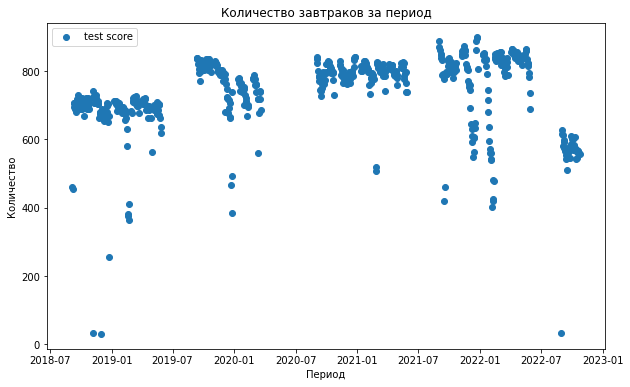

In [ ]:
df_142 = df.loc[df['Школа'] == 2000142]

plt.figure(figsize=(10,6))

plt.scatter(df_142["DATEP"], df_142["Количество"])
plt.xlabel('Период')
plt.ylabel('Количество')
plt.title("Количество завтраков за период")
plt.legend(['test score'], loc='upper left')

Из графика видно, что точки более кучны в верхней части графика в начале года, а к концу году начинают расходится на всей оси y. 
Так же стоит отметить, что на сентябрь 2022г кол-во сильно меньше, чем в сентябре предыдущих годов.
Получается, что наши данные сильно дифференцированы особенно по выделенным нашей моделью параметрам: год и месяц.

Ради эксперимента попробуем обучить нашу модель на примере только одного учреждения и только данных за прошлый и текущий учебный год

Fitting 4 folds for each of 7 candidates, totalling 28 fits


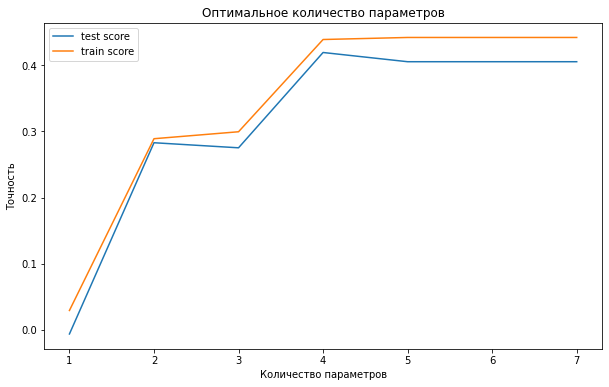

In [ ]:
# Повторим всю процедуру для датасета с данными с 01.09.2022
df_142 = df_142.loc[df_142['DATEP'] >= '2021-09-01']
col2use = ['Год','Месяц','День','День недели','День в году']

y = df_142['Количество']
X = df_142[['Год','Месяц','День','День недели','День в году']]

X_train , X_test , y_train, y_test = train_test_split(X, y, train_size=0.75, random_state = 1 )

folds = KFold(n_splits = 4, shuffle = True, random_state = 1)
hyper_params = [{'n_features_to_select': list(range(1, 8))}]

lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

model_cv.fit(X_train, y_train)                  

cv_results = pd.DataFrame(model_cv.cv_results_)
plt.figure(figsize=(10,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('Количество параметров')
plt.ylabel('Точность')
plt.title("Оптимальное количество параметров")
plt.legend(['test score', 'train score'], loc='upper left')

In [ ]:
time_test='2022-11-22'
time_test2 = datetime.strptime(time_test, '%Y-%m-%d')
time_test2_year = time_test2.year
time_test2_month = time_test2.month
time_test2_day = time_test2.day
time_test2_dayofweek = time_test2.isoweekday()
time_test2_dayofyear = int(time_test2.strftime('%j'))
x_try = [[time_test2_year,time_test2_month,time_test2_day,time_test2_dayofweek,time_test2_dayofyear]]

In [ ]:
print('Предсказание обычной линейной регрессии:', lm.predict(x_try))
print('Точность:', lm.score(X_test, y_test))
print('Предсказание линейной регрессии в GridSearchCV:', model_cv.predict(x_try))
print('Точность:', model_cv.score(X_test, y_test))

Предсказание обычной линейной регрессии: [501.55163204]
Точность: 0.5293498734238218
Предсказание линейной регрессии в GridSearchCV: [498.16260453]
Точность: 0.5352719871606326


In [ ]:
y_pred_lm=lm.predict(X_test)
y_pred_cv=model_cv.predict(X_test)
results = pd.DataFrame({'Actual': y_test, 'Predicted lm': y_pred_lm, 'Predicted CV': y_pred_cv})
print(results)

      Actual  Predicted lm  Predicted CV
1781     864    802.070099    796.639818
1857     556    574.262198    570.929941
1672     815    807.390897    798.933857
1829     542    569.416573    573.620288
1850     544    569.871819    578.224842
1685     812    808.348628    811.496485
1682     824    823.027222    813.486003
1694     852    740.530927    739.392322
1749     425    708.422337    707.406129
1692     844    750.316656    740.718667
1799     833    771.959184    780.723670
1698     873    740.279684    735.413284
1705     805    725.349848    729.444729
1723     890    740.483688    736.038801
1658     852    817.930354    812.197314
1747     403    718.208066    708.732474
1826     567    584.095166    575.609807
1804     849    792.488374    795.938990
1665     777    803.000518    806.228758
1771     814    869.636558    864.764945
1689     815    808.097386    807.517448
1753     843    708.171094    703.427092
1743     561    718.459309    712.711511
1856     560    

In [ ]:
# Cреднеквадратическая ошибка
print("Cреднеквадратическая ошибка: %.2f" % mean_squared_error(y_test, y_pred_lm))
# Коэффициент детерминации
print("Коэффициент детерминации: %.2f" % r2_score(y_test, y_pred_lm))

Cреднеквадратическая ошибка: 8953.82
Коэффициент детерминации: 0.53


In [ ]:
# Cреднеквадратическая ошибка
print("Cреднеквадратическая ошибка: %.2f" % mean_squared_error(y_test, y_pred_cv))
# Коэффициент детерминации
print("Коэффициент детерминации: %.2f" % r2_score(y_test, y_pred_cv))

Cреднеквадратическая ошибка: 8841.15
Коэффициент детерминации: 0.54


In [ ]:
# Определим параметры которые больше всего влияют на модель
feature_names = X.columns
model_coefficients = lm.coef_

coefficients_df = pd.DataFrame(data = model_coefficients, 
                              index = feature_names, 
                              columns = ['Значимость параметров'])
print(coefficients_df)

             Значимость параметров
Год                    -234.318818
Месяц                  2367.684831
День                     78.058676
День недели              -4.157992
День в году             -78.793549


При обучении модели на меньшей выборке мы видим что она стала точне:
Точность вросла на ~12%, а среднеквадратическая ошибка уменьшилась в 3 раза. Так же стоит отметить, что в отличии от первого датасета, наши модели теперь предсказывают с небольшой разницей: Модель с GridSearchCV точнее на 0,006.

# **Тест с другими моделями**
Попробуем нашу выборку с другими моделями:

In [ ]:
itog_val_determination = {}
itog_val_mean = {}

itog_val_determination['LinearRegression'] = r2_score(y_test, y_pred_lm)
itog_val_mean['LinearRegression'] = mean_squared_error(y_test, y_pred_lm)

itog_val_determination['LR+GridSearchCV'] = r2_score(y_test, y_pred_cv)
itog_val_mean['LR+GridSearchCV'] = mean_squared_error(y_test, y_pred_cv)

las = linear_model.Lasso(alpha=0.01, fit_intercept=True)
las.fit(X_train, y_train)
y_pred_las=las.predict(X_test)
itog_val_determination['Lasso'] = r2_score(y_test, y_pred_las)
itog_val_mean['Lasso'] = mean_squared_error(y_test, y_pred_las)

lasIC = linear_model.LassoLarsIC(criterion='bic', normalize=False)
lasIC.fit(X_train, y_train)
y_pred_lasIC=lasIC.predict(X_test)
itog_val_determination['LassoLarsIC'] = r2_score(y_test, y_pred_lasIC)
itog_val_mean['LassoLarsIC'] = mean_squared_error(y_test, y_pred_lasIC)

ELN = linear_model.ElasticNet(random_state=1)
ELN.fit(X_train, y_train)
y_pred_ELN=ELN.predict(X_test)
itog_val_determination['ElasticNet'] = r2_score(y_test, y_pred_ELN)
itog_val_mean['ElasticNet'] = mean_squared_error(y_test, y_pred_ELN)

lars = linear_model.Lars(n_nonzero_coefs=5, normalize=False)
lars.fit(X_train, y_train)
y_pred_lars=lars.predict(X_test)
itog_val_determination['Lars'] = r2_score(y_test, y_pred_lars)
itog_val_mean['Lars'] = mean_squared_error(y_test, y_pred_lars)

LasLars = linear_model.LassoLars(alpha=.01, normalize=False)
LasLars.fit(X_train, y_train)
y_pred_LasLars=LasLars.predict(X_test)
itog_val_determination['LassoLars'] = r2_score(y_test, y_pred_LasLars)
itog_val_mean['LassoLars'] = mean_squared_error(y_test, y_pred_LasLars)

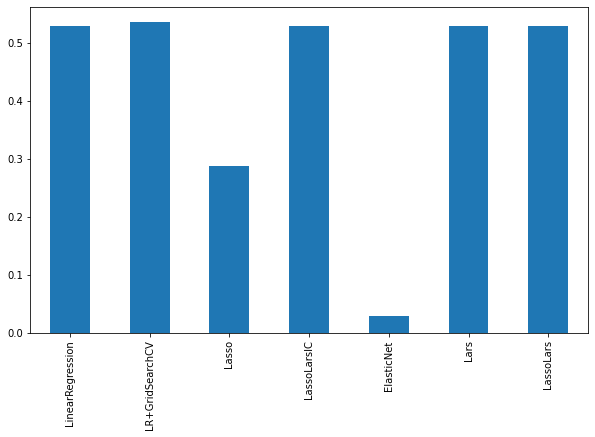

In [ ]:
pd.DataFrame.from_dict(data = itog_val_determination, orient='index').plot(kind='bar', legend=False, figsize=(10,6))

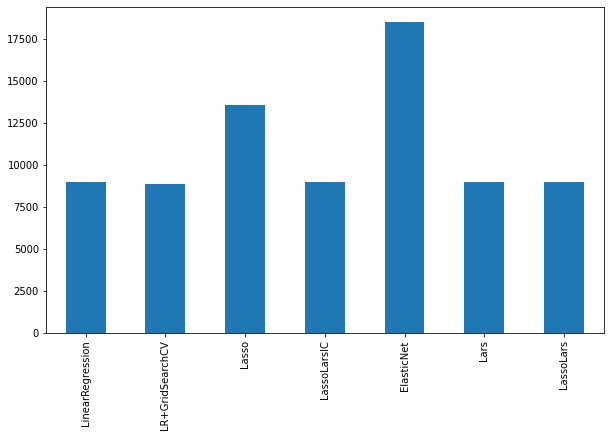

In [ ]:
pd.DataFrame.from_dict(data = itog_val_mean, orient='index').plot(kind='bar', legend=False, figsize=(10,6))

# **Выводы**
В ходе работы я опробовал различные модели машинного обучения. В среднем, все они они показали одинаковые результаты. Отдельно стоит отметить модель Лассо и модель эластичной сети, их показатели сильно ниже среднего.
При обучении на датасете за 4 года точность была в райне 0.4, при изменении периода до 1 года, точность повысилась до 0.53, что свидетельсвует а сильной корреляции данных в зависимости периода, которая произошла из-за переобучения нашей сети. Почему наша сеть переобучена? В датасете имеется информация только за дни, когда школы работали и оказывались услуги по питанию. Стоит отметить, что период с начала марта 2022г и по январь 2022г совпал с пандемией коронавируса, в виду которого школы закрывались на локдаун, а после стабилизации ситуации, вместо локдауна в случае заболевания детей на карантин уходили целые классы. Также не стоит забывать про различные мотивационные мероприятия по увеличению численности питающихся, таких как перевод питания в начальных классах на бюджетную основу и других. Все эти факторы создают огромный разброс данных, который сложно спрогнозировать лишь по набору параметров связанных с датой. 
В качестве развития данной идеи я вижу несколько изменений:

1.   Изменения входных параметров, например попробовать обучать не только исходя из даты, но и из численности детей за каждый день.
2.   В качестве опыта я использовал только данные по завтракам, можно увеличить модель и получать данные по другим видам питания: обеды, полдники, диетическое питания и.т.п
3.   На основании полученных количественных данных и данных меню-раскладки в том же 1С можно высчитать необходимое число продуктов для предварительной закупки